In [1]:
from huggingface_hub import notebook_login

In [2]:
notebook_login()

In [3]:
cache_dir = "/data/home/geshi/data"

In [4]:
from datasets import load_dataset

In [5]:
dataset = load_dataset("openbmb/RLHF-V-Dataset", split="train[:1%]")

In [6]:
sample = dataset[1]

In [7]:
sample

{'ds_name': 'RLHF-V-Dataset',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'text': '{"question": "What kind of potato chips are on the plate?", "chosen": "There are some light yellow thin slice-shaped potato chips in this plate, which look very crispy.", "rejected": "This plate contains Doritos chips."}',
 'origin_dataset': 'vqav2',
 'origin_split': '{"model": "InstructBLIP-Flan-T5-xxl", "type": "question_answering"}',
 'idx': 1,
 'image_path': 'coco2017/train2017/000000179545.jpg'}

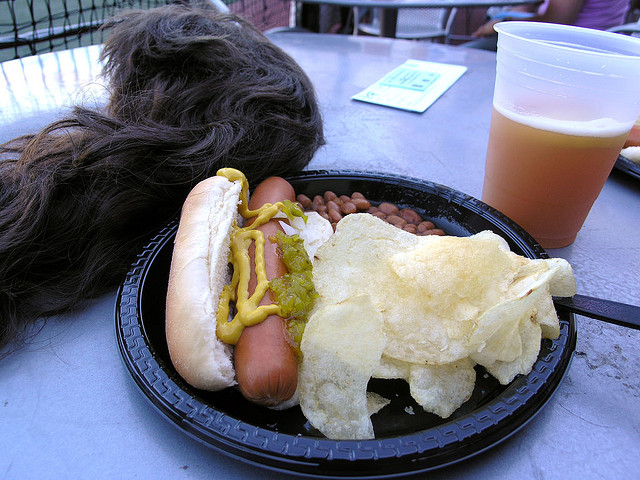

In [8]:
sample["image"]

In [9]:
import json

In [10]:
sample_text = json.loads(sample["text"])

In [11]:
sample_text

{'question': 'What kind of potato chips are on the plate?',
 'chosen': 'There are some light yellow thin slice-shaped potato chips in this plate, which look very crispy.',
 'rejected': 'This plate contains Doritos chips.'}

In [12]:
from datasets import features

In [13]:
from transformers import AutoProcessor

In [14]:
processor = AutoProcessor.from_pretrained("HuggingFaceM4/idefics2-8b", do_image_splitting=False)

processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

In [15]:
def format(example):
    example_text = json.loads(example["text"])
    # Prepare the input for the chat template
    prompt = [
        {
            "role": "user",
            "content": [{"type": "image"}, {"type": "text", "text": example_text["question"]}],
        },
    ]
    chosen = [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": example_text["chosen"]}],
        },
    ]
    rejected = [
        {
            "role": "assistant",
            "content": [{"type": "text", "text": example_text["rejected"]}],
        },
    ]
    # Apply the chat template
    prompt = processor.apply_chat_template(prompt, tokenize=False)
    chosen = processor.apply_chat_template(chosen, tokenize=False)
    rejected = processor.apply_chat_template(rejected, tokenize=False)
    # Resize the image to ensure it fits within the maximum allowable
    # size of the processor to prevent OOM errors.
    max_size = processor.image_processor.size["longest_edge"]
    example["image"].thumbnail((max_size, max_size))
    return {"images": [example["image"]], "prompt": prompt, "chosen": chosen, "rejected": rejected}

In [16]:
dataset = dataset.map(format, remove_columns=dataset.column_names)

In [17]:
f = dataset.features
f["images"] = features.Sequence(features.Image(decode=True))  # to avoid bytes
dataset = dataset.cast(f)

In [18]:
dataset[1]

{'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>],
 'prompt': 'User:<image>What kind of potato chips are on the plate?<end_of_utterance>\n',
 'chosen': 'Assistant: There are some light yellow thin slice-shaped potato chips in this plate, which look very crispy.<end_of_utterance>\n',
 'rejected': 'Assistant: This plate contains Doritos chips.<end_of_utterance>\n'}

# Training

In [22]:
import torch
from transformers import AutoModelForVision2Seq
from peft import get_peft_model, LoraConfig

In [20]:
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceM4/idefics2-8b", torch_dtype=torch.bfloat16, cache_dir=cache_dir)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [23]:
peft_config = LoraConfig(target_modules="all-linear")

In [24]:
model = get_peft_model(model, peft_config)

In [25]:
model.print_trainable_parameters()

trainable params: 27,674,368 || all params: 8,430,442,480 || trainable%: 0.3283


In [28]:
from transformers import TrainingArguments
from trl import DPOConfig, DPOTrainer

[2024-09-09 12:57:06,298] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  using untested triton version (2.2.0), only 1.0.0 is known to be compatible


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [34]:
training_args = DPOConfig(
    output_dir="idefics2-8b-dpo-RLHF-V",
    bf16=True,
    gradient_checkpointing=True,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=32,
    num_train_epochs=1,
    dataset_num_proc=32,  # tokenization will use 32 processes
    dataloader_num_workers=32,  # data loading will use 32 workers
    logging_steps=10,
)

In [35]:
trainer = DPOTrainer(
    model,
    ref_model=None,  # not needed when using peft
    args=training_args,
    train_dataset=dataset,
    tokenizer=processor,
    peft_config=LoraConfig(target_modules="all-linear"),
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacity of 23.69 GiB of which 80.56 MiB is free. Including non-PyTorch memory, this process has 23.60 GiB memory in use. Of the allocated memory 22.99 GiB is allocated by PyTorch, and 153.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [36]:
trainer.train()

AttributeError: `AcceleratorState` object has no attribute `distributed_type`. This happens if `AcceleratorState._reset_state()` was called and an `Accelerator` or `PartialState` was not reinitialized.